In [1]:
from time import perf_counter 
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sopt

import tensorflow as tf

In [2]:
# Code to use the scipy optimizers

# use float64 by default
tf.keras.backend.set_floatx("float64")

# Reshape 1D arrays to 2D arrays
def reshape_2d(x):
    return tf.reshape(x,(x.shape[0],1))

# Construct a function that can be minimized by scipy optimize
# starting from a tensorflow model
def function_factory(model, x_train, y_train, validation_data=None,
                     iprint=-1):
    """A factory to create a function required by scipy.optimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        x_train [in]: input for training data.
        y_train [in]: output for training data.
        validation_data [in]: tuple (x_val,y_val) with validation data.
        iprint [in]: sets the frequency with which the loss info is printed out
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters)
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = []  # stitch indices
    part = []  # partition indices

    for i, tensor in enumerate(model.trainable_variables):
        n = np.product(tensor.shape)
        idx.append(tf.reshape(
            tf.range(count, count+n, dtype=tf.int32), tensor.shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)
    
    loss_fun = tf.keras.losses.MeanSquaredError()

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """
        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # function to calculate loss value and gradient
    @tf.function
    def tf_tape_grad(params_1d):

        # update the parameters in the model
        assign_new_model_parameters(params_1d)       

        if not (validation_data is None):
          # compute validation loss
          loss_val = model.loss(validation_data[0], validation_data[1])
          # store validation value so we can retrieve later        
          tf.py_function(value_and_grad.hist_loss_val.append,
                        inp=[loss_val], Tout=[])         
              
        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as g:
            g.watch(model.trainable_variables)
            loss = model.loss(x_train,y_train)

        # calculate gradients and convert to 1D tf.Tensor
        grads = g.gradient(loss, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        # increment iteration counter
        value_and_grad.iter.assign_add(1)

        # print out iteration & loss
        if (iprint>=1 and value_and_grad.iter%iprint == 0):
            if validation_data is None:
                tf.print("Loss function eval:", value_and_grad.iter, "loss:", loss)
            else:
                tf.print("Loss function eval:", value_and_grad.iter, "loss:", loss,
                        "validation loss:", loss_val)                

        # store loss value so we can retrieve later
        tf.py_function(value_and_grad.hist_loss.append,
                       inp=[loss], Tout=[])       

        return loss, grads

    # create function that will be returned by this factory
    def value_and_grad(params_1d):
        """A function that can be used by optimizer.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """
        return [vv.numpy().astype(np.float64) for vv in tf_tape_grad(tf.constant(params_1d, dtype=tf.float64))]

    # store this information as members so we can use it outside the scope
    value_and_grad.iter = tf.Variable(0)
    value_and_grad.idx = idx
    value_and_grad.part = part
    value_and_grad.shapes = shapes
    value_and_grad.assign_new_model_parameters = assign_new_model_parameters
    value_and_grad.hist_loss = []
    value_and_grad.hist_loss_val = []

    return value_and_grad


# Minimize the loss function using a scipy optimizer
def model_fit(model, x_t, y_t, validation_data=None, epochs=1000, iprint=-1,
              figname=None):
    """ 
    Fit a DNN model using scipy optimizers 
  
  
    Parameters: 
    model: tensorflow DNN model
    x_t: input training data
    y_t: output training data
    validation_data: tuple (x_val,y_val) with validation data
    epochs: maximum number of iterations in optimizer
    iprint: frequency for printing the loss function information. 
            Do not print anything if negative. Otherwise, print
            a line every iprint iteration.
    figname [str]: file name to save the figure of the training loss  
    """

    value_and_grad = function_factory(model, x_t, y_t, validation_data, iprint)

    # convert initial model parameters to a 1D tf.Tensor
    init_params = tf.dynamic_stitch(value_and_grad.idx, model.trainable_variables)

    if (iprint>=1):
        print()

    # train the model
    method = 'L-BFGS-B'
    results = sopt.minimize(fun=value_and_grad, x0=init_params,
                            jac=True, method=method,
                            options={'maxiter': epochs})

    print("\nConvergence information:")
    print('loss:', results.fun)
    # Computing the validation loss  
    if not (validation_data is None):
        val_loss = model.loss(validation_data[0], validation_data[1])
        tf.print('validation loss:', val_loss)
        # tf.make_ndarray(tf.make_tensor_proto(val_loss))    
    print('number function evaluations:', results.nfev)
    print('number iterations:', results.nit)
    print('success flag:', results.success)
    print('convergence message:', results.message)

    value_and_grad.assign_new_model_parameters(results.x)

    # Plot history of loss
    plt.figure()   
    plt.plot(value_and_grad.hist_loss, label='loss')
    if not (validation_data is None): 
        plt.plot(value_and_grad.hist_loss_val, label='validation')
    plt.legend()
    plt.xlabel('epoch')
    plt.yscale('log')
    if validation_data is None:    
        plt.title('Training loss')
    else:
        plt.title('Training and validation losses')

    if not (figname is None):
        plt.savefig(figname,dpi=300)

    return results

Solve the equation: 

$u'' = -\cos(x)$


Loss function eval: 200 loss: 2.0100580648829691e-05

Convergence information:
loss: 7.188943732250319e-07
number function evaluations: 389
number iterations: 356
success flag: True
convergence message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


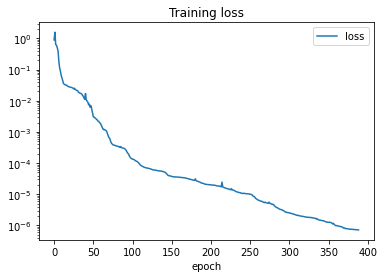

In [3]:
class PI_Model_1D(tf.keras.models.Model):
    def __init__(self):
        super(PI_Model_1D, self).__init__()
        
        # Define all layers
        self.dense_1 = tf.keras.layers.Dense(16, activation=tf.keras.activations.tanh)
        self.dense_2 = tf.keras.layers.Dense(16, activation=tf.keras.activations.tanh)        
        self.dense_3 = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
        
        # Loss function to use later on
        self.loss_fun = tf.keras.losses.MeanSquaredError()
            
    # Forward pass for model
    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)        
        u = self.dense_3(x)
        return u        

    def get_derivatives(self, x):
        tensor_x = tf.constant(x, dtype=tf.float64)
        with tf.GradientTape() as g:
            g.watch(tensor_x)
            with tf.GradientTape() as gg:
                gg.watch(tensor_x)
                u = self(tensor_x, training=True)
            u_x = gg.gradient(u,tensor_x)
        u_xx = g.gradient(u_x,tensor_x)
        return u, u_x, u_xx
    
    def loss(self, X, Y):
        # data observation loss    
        u = self(X[0])
        # PDE loss        
        _, _, u_xx = self.get_derivatives(X[1])
        pde = u_xx       
        loss = self.loss_fun(Y[0], u) + self.loss_fun(Y[1], pde)    
        return loss
    
# Initialize model    
model = PI_Model_1D()
model.build((1,1))

# values of u in the training set
n_train_obs = 4
x_train_obs = np.reshape(np.linspace(-math.pi/2,math.pi/2,n_train_obs),(n_train_obs,1))
y_train_obs = np.cos(x_train_obs)

# values for right-hand-side of the PDE in the training set
n_train_pde = 32
x_train_pde = np.reshape(np.linspace(-math.pi,math.pi,n_train_pde),(n_train_pde,1))
y_train_pde = -np.cos(x_train_pde)

X_train = [x_train_obs,x_train_pde]
Y_train = [y_train_obs,y_train_pde]

result = model_fit(model, X_train, Y_train, epochs=1000, iprint=200)

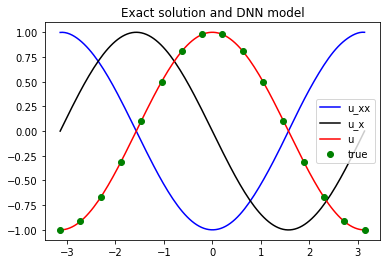

In [4]:
# Plot the solution

x_true = reshape_2d(np.linspace(-math.pi,math.pi,16))
x_test = reshape_2d(np.linspace(-math.pi,math.pi,128))

u_pred, u_x_pred, u_xx_pred = model.get_derivatives(x_test)

plt.plot(x_test,u_xx_pred,'b',label='u_xx')
plt.plot(x_test,u_x_pred,'k',label='u_x')
plt.plot(x_test,u_pred,'r',label='u')
plt.plot(x_true,np.cos(x_true),'go',label='true')
plt.title('Exact solution and DNN model')
plt.legend()
plt.show()

Solve the equation in 2D:

$$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 2 - 5 \cos(x + 2y)$$

Solution is:

$$u(x,y) = x^2 + \cos(x + 2y) + x y$$


Loss function eval: 200 loss: 0.00086287627345882356
Loss function eval: 400 loss: 0.00010782538083731197
Loss function eval: 600 loss: 4.1377803427167237e-05
Loss function eval: 800 loss: 1.7572884644323494e-05
Loss function eval: 1000 loss: 1.1021437330782646e-05

Convergence information:
loss: 1.0274559713252529e-05
number function evaluations: 1064
number iterations: 1000
success flag: False
convergence message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'


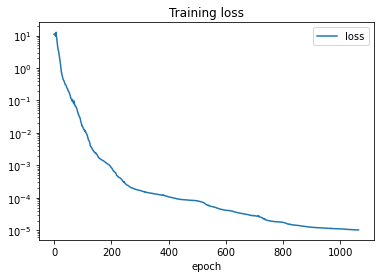

In [5]:
class PI_Model_2D(tf.keras.models.Model):
    def __init__(self):
        super(PI_Model_2D, self).__init__()
        # Define all layers
        self.dense_1 = tf.keras.layers.Dense(16, activation=tf.keras.activations.tanh)
        self.dense_2 = tf.keras.layers.Dense(16, activation=tf.keras.activations.tanh)        
        self.dense_3 = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
        
        # Loss function to use later on
        self.loss_fun = tf.keras.losses.MeanSquaredError()
            
    # Forward pass for model
    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)        
        u = self.dense_3(x)
        return u        

    def get_derivatives(self, x):
        x1 = tf.constant(x[:,0], dtype=tf.float64)
        x2 = tf.constant(x[:,1], dtype=tf.float64)
        with tf.GradientTape(persistent=True) as g:
            g.watch(x1)
            g.watch(x2)            
            with tf.GradientTape() as gg:
                gg.watch(x1)
                gg.watch(x2)
                x = tf.stack([x1, x2], 1)                
                u = self(x, training=True)
            [u_x, u_y] = gg.gradient(u,[x1,x2])
        u_xx = g.gradient(u_x,x1)
        u_yy = g.gradient(u_y,x2)
        del g
        return u, u_x, u_y, u_xx, u_yy
    
    def loss(self, X, Y):
        # data observation loss    
        u = self(X[0])
        # PDE loss
        _, _, _, u_xx, u_yy = self.get_derivatives(X[1])
        pde = u_xx + u_yy     
        loss = self.loss_fun(Y[0], u) + self.loss_fun(Y[1], pde)
        return loss

# Initialize model
model = PI_Model_2D()
model.build((1,2))

def f(x,y):
    return x**2 + np.cos(x + 2*y) + x * y

def pde_rhs(x,y):
    return 2 - 5 * np.cos(x + 2*y)

# helper function
def get_x_data(n1_train,n2_train):
    x1 = np.linspace(-1.,1.,n1_train)
    x2 = np.linspace(-1.,1.,n2_train)
    x1_m, x2_m = np.meshgrid(x1, x2, sparse=False, indexing='ij')
    X = np.zeros((n1_train*n2_train,2))        
    X[:,0] = np.reshape(x1_m,(n1_train*n2_train))
    X[:,1] = np.reshape(x2_m,(n1_train*n2_train))
    return X

# observation data
n1_obs = 4
n2_obs = 4
x_train_obs = get_x_data(n1_obs,n2_obs)        
y_train_obs = f(x_train_obs[:,0],x_train_obs[:,1])
y_train_obs = reshape_2d(y_train_obs)

# PDE data
n1_pde = 8
n2_pde = 8
x_train_pde = get_x_data(n1_pde,n2_pde)        
y_train_pde = pde_rhs(x_train_pde[:,0],x_train_pde[:,1])
y_train_pde = reshape_2d(y_train_pde)

X_train = [x_train_obs,x_train_pde]
Y_train = [y_train_obs,y_train_pde]

result = model_fit(model, X_train, Y_train, epochs=1000, iprint=200)

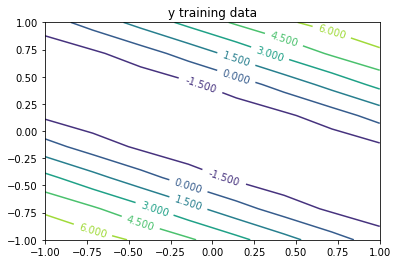

In [6]:
x1 = np.linspace(-1.,1.,n1_pde)
x2 = np.linspace(-1.,1.,n2_pde)
x1_m, x2_m = np.meshgrid(x1, x2, sparse=False, indexing='ij')
fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,np.reshape(y_train_pde,(x1.size,x2.size)))
ax.clabel(CS, inline=1, fontsize=10)
plt.title('y training data')
plt.show()

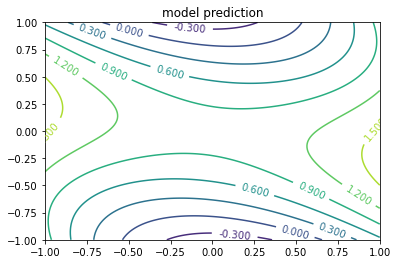

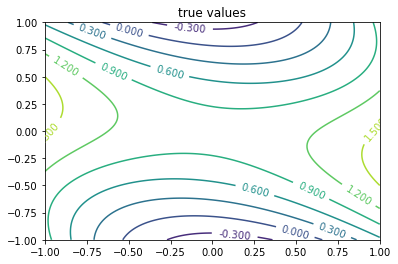

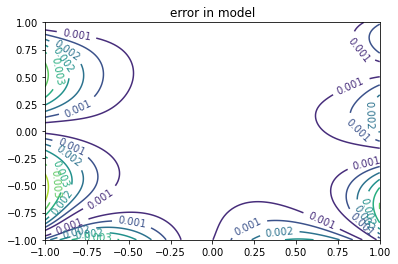

In [7]:
n_plt = 128
x1 = np.linspace(-1.,1.,n_plt)
x2 = np.linspace(-1.,1.,n_plt)
x1_m, x2_m = np.meshgrid(x1, x2, sparse=False, indexing='ij')

x_test = get_x_data(n_plt,n_plt) 
u = model(x_test)
u = np.reshape(u,(n_plt,n_plt))

fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,u)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('model prediction')
plt.savefig('fig/piml_1.png',dpi=300)

u_exact = f(x1_m,x2_m)
fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,u_exact)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('true values')
plt.savefig('fig/piml_2.png',dpi=300)

fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,np.abs(u-u_exact))
ax.clabel(CS, inline=1, fontsize=10)
plt.title('error in model')
plt.savefig('fig/piml_3.png',dpi=300)

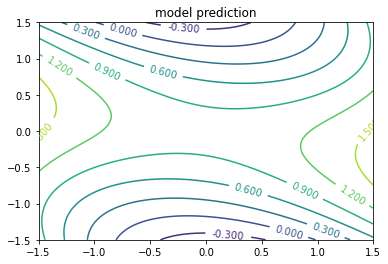

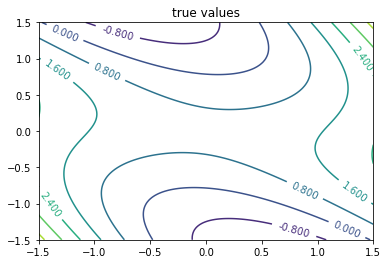

In [8]:
# Plotting the model outside of the training region

n_plt = 128
x1 = np.linspace(-1.5,1.5,n_plt)
x2 = np.linspace(-1.5,1.5,n_plt)
x1_m, x2_m = np.meshgrid(x1, x2, sparse=False, indexing='ij')

x_test = get_x_data(n_plt,n_plt) 
u = model(x_test)
u = np.reshape(u,(n_plt,n_plt))

fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,u)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('model prediction')
plt.show()

u_exact = f(x1_m,x2_m)
fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,u_exact)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('true values')
plt.show()

Solving for $u(x,y)$ and $k(x,y)$.

The PDE is:

$ \nabla \cdot ( k \nabla u ) = f $

Exact value for $u$:

$u(x,y) = x^2 + y^2$

$\nabla u = [2x,2y]$

Exact value of $k$:

$k = 1 + x^2$

$k \nabla u = [2x(1+x^2),2y(1+x^2)]$

Exact value for $f = \nabla \cdot ( k \nabla u )$

$f = 8x^2 + 4$


Loss function eval: 500 loss: 6.8228172676754187e-05
Loss function eval: 1000 loss: 1.3704123034585791e-05

Convergence information:
loss: 1.3087443812764832e-05
number function evaluations: 1039
number iterations: 956
success flag: True
convergence message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


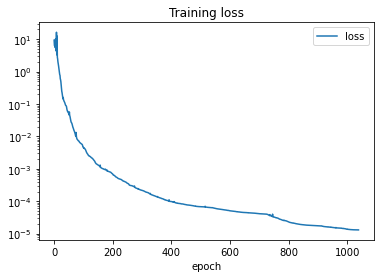

In [9]:
class PI_u_k(tf.keras.models.Model):
    def __init__(self):
        super(PI_u_k, self).__init__()
        # Define all layers
        self.dense_1 = tf.keras.layers.Dense(16, activation=tf.keras.activations.tanh)
        self.dense_2 = tf.keras.layers.Dense(16, activation=tf.keras.activations.tanh)        
        self.dense_3 = tf.keras.layers.Dense(2, activation=tf.keras.activations.linear)
        
        # Loss function to use later on
        self.loss_fun = tf.keras.losses.MeanSquaredError()
            
    # Forward pass for model
    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)        
        z = self.dense_3(x)
        return z

    def get_derivatives(self, x):
        x1 = tf.constant(x[:,0], dtype=tf.float64)
        x2 = tf.constant(x[:,1], dtype=tf.float64)
        with tf.GradientTape(persistent=True) as g:
            g.watch(x1)
            g.watch(x2)            
            with tf.GradientTape() as gg:
                gg.watch(x1)
                gg.watch(x2)
                x = tf.stack([x1, x2], 1)                
                z = self(x)
                u, k = tf.split(z, num_or_size_splits=2, axis=1)
            [u_x, u_y] = gg.gradient(u, [x1,x2])
            u_x = tf.reshape( u_x, (x1.shape[0], 1) )
            u_y = tf.reshape( u_y, (x2.shape[0], 1) )
            k_ux = k * u_x
            k_uy = k * u_y
        pde = g.gradient(k_ux,x1) + g.gradient(k_uy,x2)
        del g
        return u, k, u_x, u_y, pde
    
    def loss(self, X, Y):
        # u data observation loss
        u = self(X[0])[:,0]
        # k data observation loss    
        k = self(X[1])[:,1]
        # PDE loss
        _, _, _, _, pde = self.get_derivatives(X[2])
        loss = self.loss_fun(Y[0], u)\
                + self.loss_fun(Y[1], k)\
                + 0.1 * self.loss_fun(Y[2], pde)
        return loss

# Initialize model
model = PI_u_k()
model.build((1,2))

def u_fun(x,y):
    return x**2 + y**2

def k_fun(x,y):
    return 1 + x**2

def f_fun(x,y):
    return 8*x**2 + 4

# u observation data
n1_u_obs = 4
n2_u_obs = 4
x_u_obs = get_x_data(n1_u_obs,n2_u_obs)        
u_obs = u_fun(x_u_obs[:,0],x_u_obs[:,1])
u_obs = reshape_2d(u_obs)

# k observation data
n1_k_obs = 16
n2_k_obs = 16
x_k_obs = get_x_data(n1_k_obs,n2_k_obs)        
k_obs = k_fun(x_k_obs[:,0],x_k_obs[:,1])
k_obs = reshape_2d(k_obs)

# PDE data
n1_pde = 16
n2_pde = 16
x_pde = get_x_data(n1_pde,n2_pde)        
y_pde = f_fun(x_pde[:,0],x_pde[:,1])
y_pde = reshape_2d(y_pde)

X_train = [x_u_obs,x_k_obs,x_pde]
Y_train = [u_obs,k_obs,y_pde]

result = model_fit(model, X_train, Y_train, epochs=10000, iprint=500)

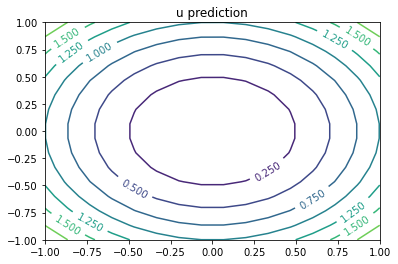

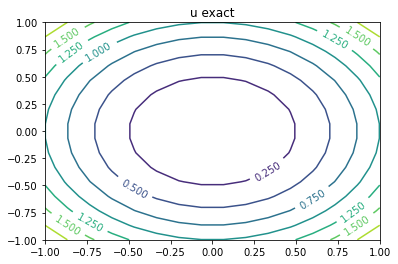

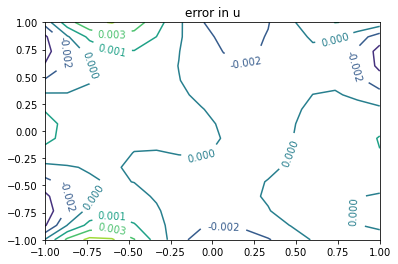

In [10]:
n_plt = 16
x1 = np.linspace(-1.,1.,n_plt)
x2 = np.linspace(-1.,1.,n_plt)
x1_m, x2_m = np.meshgrid(x1, x2, sparse=False, indexing='ij')

x_test = get_x_data(n_plt,n_plt) 
z = model.get_derivatives(x_test)
u = np.reshape(z[0], (n_plt,n_plt))

fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,u)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('u prediction')
plt.savefig('fig/piml_4.png',dpi=300)

exact = u_fun(x1_m,x2_m)
fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,exact)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('u exact')
plt.savefig('fig/piml_5.png',dpi=300)

fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,u-exact)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('error in u')
plt.savefig('fig/piml_6.png',dpi=300)

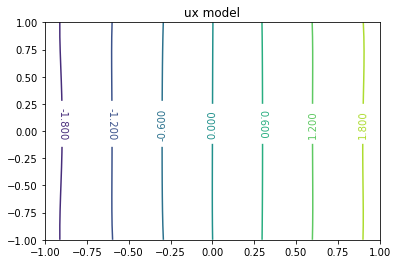

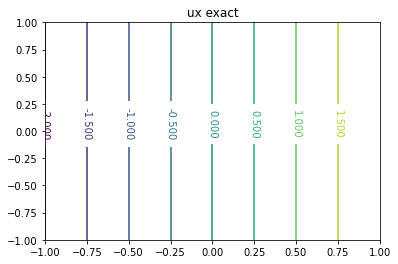

In [11]:
z = model.get_derivatives(x_test)
ux = tf.reshape( z[2], (x_test.shape[0], 1) )
# ux = np.reshape(z[2], (n_plt,n_plt))
ux = np.reshape(ux, (n_plt,n_plt))

fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,ux)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('ux model')
plt.show()

fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,2*x1_m)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('ux exact')
plt.show()

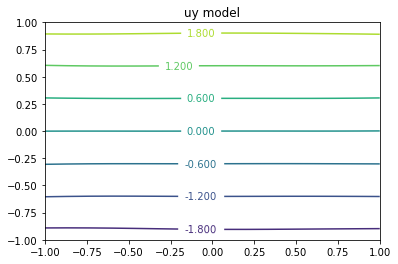

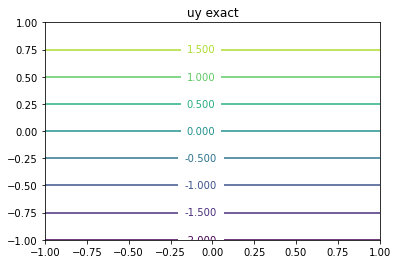

In [12]:
z = model.get_derivatives(x_test)
uy = np.reshape(z[3], (n_plt,n_plt))

fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,uy)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('uy model')
plt.show()

fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,2*x2_m)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('uy exact')
plt.show()

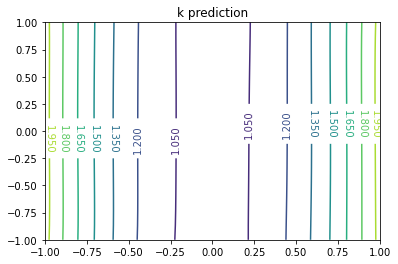

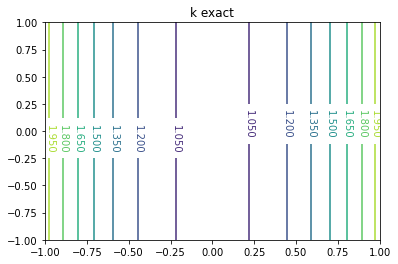

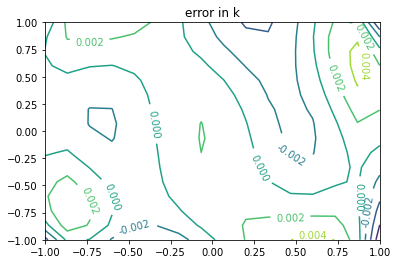

In [13]:
z = model.get_derivatives(x_test)
k = np.reshape(z[1],(n_plt,n_plt))

fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,k)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('k prediction')
plt.savefig('fig/piml_7.png',dpi=300)

exact = k_fun(x1_m,x2_m)
fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,exact)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('k exact')
plt.savefig('fig/piml_8.png',dpi=300)

fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,k-exact)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('error in k')
plt.savefig('fig/piml_9.png',dpi=300)

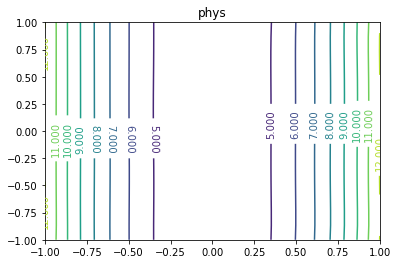

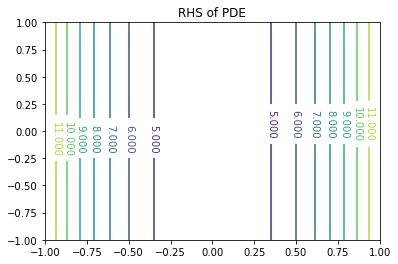

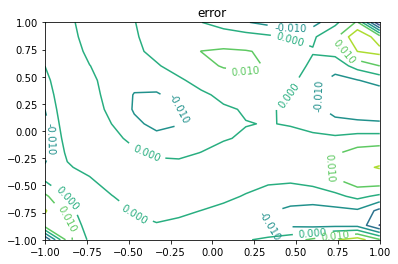

In [14]:
z = model.get_derivatives(x_test)
div = np.reshape(z[4],(n_plt,n_plt))

f = f_fun(x_test[:,0],x_test[:,1])
f = np.reshape(f,(n_plt,n_plt))

fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,div)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('phys')
plt.savefig('fig/piml_10.png',dpi=300)

fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,f)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('RHS of PDE')
plt.savefig('fig/piml_11.png',dpi=300)

fig, ax = plt.subplots()
CS = ax.contour(x1_m,x2_m,div-f)
ax.clabel(CS, inline=1, fontsize=10)
plt.title('error')
plt.savefig('fig/piml_12.png',dpi=300)